 Importing libraries and downloading MNIST data

In [12]:
import torch
#import torch.nn as nn
#import torch.functional as F
import torchvision.datasets as dset
from torch.utils.data import Dataset, TensorDataset
from torchvision.transforms import ToTensor

#import torchvision.transforms as transforms

input_traindata = dset.MNIST( root="./data", train = True, transform = ToTensor(),
                          download= True)

ny,nx = input_traindata.data[0].shape
input_traindata = input_traindata.data.float()/255


Defining A matrix and Theta steps

In [13]:

import numpy as np
from skimage.transform import radon,rescale,resize


theta = np.linspace(0.,180.,26, endpoint=False)

def getRadonMatrix(theta,ny,nx):
    colum_of_A = radon(np.zeros((ny,nx)), theta=theta)  #  this is just to know the size of this
    A = np.zeros((colum_of_A.size,nx*ny))
    for i in range(ny):
        for j in range(nx):
            basis_vec = np.zeros((ny,nx))
            basis_vec[i,j] = 1
            colum_of_A = radon(basis_vec, theta=theta)
            A[:,j+i*nx] = np.reshape(colum_of_A, colum_of_A.size)
            
    return A

    

Generating Sinograms and adding Noise to the Sinogram images 

In [14]:
noise_level = 0.01
A = getRadonMatrix(theta,ny,nx)
sinograms = torch.reshape((torch.reshape(input_traindata.data, (input_traindata.data.shape[0], input_traindata.data.shape[1]*input_traindata.data.shape[2])) @ A.T),
                          (input_traindata.data.shape[0], len(theta),ny))
sinogram_noisy = sinograms + noise_level*torch.randn(sinograms.shape)

C:\Users\asvp0\Anaconda3\envs\dl21\lib\site-packages\skimage\transform\radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


Custom dataset with sinogram noisy images and image data as labels

In [15]:
train_data =TensorDataset(torch.reshape(sinogram_noisy,(sinogram_noisy.shape[0],sinogram_noisy.shape[1]*sinogram_noisy.shape[2])), torch.reshape(input_traindata.data,(input_traindata.data.shape[0], input_traindata.data.shape[1]*input_traindata.data.shape[2])))



In [5]:

trainloader = torch.utils.data.DataLoader(train_data, batch_size=60, shuffle=True)
len(trainloader)

1000

setting neural network along with the loss and ADAM Optimizer

In [10]:
import torch.nn as nn
class my_network(nn.Module):
    def __init__(self,dimension_of_sinogram , number_of_pixels):
        super(my_network,self).__init__()
        self.fc1 = nn.Linear(dimension_of_sinogram , number_of_pixels, bias=False)
        self.double()
        
    def forward(self, x):
        return self.fc1(x)

    

In [12]:
model = my_network(A.shape[0],  A.shape[1])
criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
model=model.double()
number_of_epochs = 10
for epoch in range(number_of_epochs):
    # move from full batch Adam to STOCHASTIC Adam ->> work with minibatches! 
    
    ## all that is left to do is shuffle the data every epoch
    for i,ele in enumerate(trainloader):
        batch_input,batch_output = ele
        prediction = model(batch_input)
        loss = criterion(prediction, batch_output.double())
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    if epoch%1==0:
        print(loss)

tensor(0.0268, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.0210, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.0220, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.0199, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.0127, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.0127, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.0419, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.0065, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.0141, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.0059, dtype=torch.float64, grad_fn=<MseLossBackward0>)


Making a prediction with the learned model

In [13]:
prediction = model(torch.reshape(sinogram_noisy,(sinogram_noisy.shape[0],sinogram_noisy.shape[1]*sinogram_noisy.shape[2]))[0].double())

Plotting results and Label image 

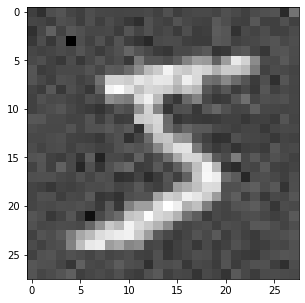

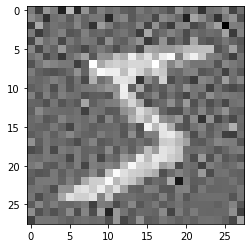

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.imshow(np.reshape(prediction.detach().numpy(), (ny,nx)), cmap='gray')
plt.show()
pseudo_inverse_of_A = np.linalg.pinv(A)
reconstruction = pseudo_inverse_of_A@torch.reshape(sinogram_noisy,(sinogram_noisy.shape[0],sinogram_noisy.shape[1]*sinogram_noisy.shape[2]))[0].detach().numpy()
plt.imshow(np.reshape(reconstruction, (ny,nx)), cmap='gray')
